In [1]:
import os
import glob
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
    
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet

In [168]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_directory = "./data/CEBS/m001"
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_db = 5

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

num_epochs = 50
batch_size = 4
learning_rate = 0.001

In [3]:
def signaltonoise_dB(signal_clean, signal_noisy):
    signal_clean_watts = signal_clean ** 2
    signal_clean_avg_watts = np.mean(signal_clean_watts)
    signal_clean_avg_db = 10 * np.log10(signal_clean_avg_watts)

    noise = signal_noisy - signal_clean
    noise_watts = noise ** 2
    noise_avg_watts = np.mean(noise_watts)
    noise_avg_db = 10 * np.log10(noise_avg_watts)

    return signal_clean_avg_db - noise_avg_db

In [4]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    # frequency = metadata['fs']
    column_names = metadata['sig_name']
    # length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    # frequency_string = str(int(1/frequency*1000000)) + 'U'
    # index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    # data.set_index(index, inplace=True)
    # data.resample(sampling_rate).mean().SCG
    
    return data

In [5]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    frequency = 5000
    length = data.shape[0]
    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)

    return data

In [6]:
def add_gaussian(data, target_snr_db):
    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

In [163]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        data = load_datasets('./data/CEBS/')
        data = data.resample(sampling_rate).mean().SCG

        data_noisy = add_gaussian(data, target_snr_db)
        data = pd.DataFrame({'clean': data, 'noise': data_noisy})


        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        for column in data.columns:
            data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

        data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [162]:
dataset = SCGData(transform=ToTensor())

In [164]:
print(dataset[0][1])

tensor([0.4967, 0.4972, 0.4986,  ..., 0.4966, 0.4964, 0.4975])


In [137]:
class DeNoise(nn.Module):
    def __init__(self):
        super(DeNoise, self).__init__()

        # self.lin_t1 = nn.Linear(500, segment_size_samples)
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 40, 16, stride=2), # (1024 - 16 +2*0) / 2 + 1 = 505
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 20, 16, stride=2), # (505 - 16 +2*0) / 2 + 1 = 245
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Conv1d(20, 20, 16, stride=2), # (245 - 16 +2*0) / 2 + 1 = 115
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Conv1d(20, 20, 16, stride=2), # (115 - 16 +2*0) / 2 + 1 = 50
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Conv1d(20, 40, 16, stride=2), # (50 - 16 +2*0) / 2 + 1 = 18
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 1, 16, stride=1) # (18 - 16 +2*0) / 1 + 1 = 3
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, 16, stride=1), # (3 - 1) * 1 + 16 = 18
            #nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, 40, 16, stride=2), # (18 - 1) * 2 + 16 = 50
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 20, 16, stride=2), # (50 - 1) * 2 + 16 = 114
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.ConvTranspose1d(20, 20, 16, stride=2), # (114 - 1) * 2 + 16 = 242
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.ConvTranspose1d(20, 20, 16, stride=2), # (242 - 1) * 2 + 16 = 498
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.ConvTranspose1d(20, 40, 16, stride=2), # (498 - 1) * 2 + 16 = 1010
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 1, 15, stride=1) # (1010 - 1) * 1 + 15 = 1024
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [141]:
class DeNoise2(nn.Module):
    def __init__(self):
        super(DeNoise2, self).__init__()

        # self.lin_t1 = nn.Linear(500, segment_size_samples)
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p
        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Linear(256, 128),
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Linear(128, 64),
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Linear(64, 32),
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Linear(32, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            #nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Linear(32, 64),
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Linear(64, 128),
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Linear(128, 256),
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Linear(512, 1024),
            #nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Linear(1024, 1024),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [169]:
model = DeNoise().to(device)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
n_total_steps = len(dataloader)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# conv1 = nn.Conv1d(1, 40, 16, stride=2)

def train(n_epochs, model):
    
    for epoch in range(n_epochs):
        trainloss = 0.0
        for i, (inputs, lables) in enumerate(dataloader):
            inputs = inputs.view(-1, 1, segment_size_samples)
            lables = lables.view(-1, 1, segment_size_samples)
            #print(inputs.shape)
            #print(lables.shape)

            inputs = inputs.to(device)
            lables = lables.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            #print(output.shape)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()

            if (i + 1) % 300 == 0:
                print(f'epoch {epoch + 1} / {n_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.4f}')

train(num_epochs, model)

FILE = 'model.pth'
torch.save(model.state_dict(), FILE)

epoch 1 / 50, step 300 / 1714, loss = 0.0044
epoch 1 / 50, step 600 / 1714, loss = 0.0019
epoch 1 / 50, step 900 / 1714, loss = 0.0007
epoch 1 / 50, step 1200 / 1714, loss = 0.0004
epoch 1 / 50, step 1500 / 1714, loss = 0.0002
epoch 2 / 50, step 300 / 1714, loss = 0.0001
epoch 2 / 50, step 600 / 1714, loss = 0.0000
epoch 2 / 50, step 900 / 1714, loss = 0.0000
epoch 2 / 50, step 1200 / 1714, loss = 0.0000
epoch 2 / 50, step 1500 / 1714, loss = 0.0000
epoch 3 / 50, step 300 / 1714, loss = 0.0000
epoch 3 / 50, step 600 / 1714, loss = 0.0000
epoch 3 / 50, step 900 / 1714, loss = 0.0000
epoch 3 / 50, step 1200 / 1714, loss = 0.0000
epoch 3 / 50, step 1500 / 1714, loss = 0.0000
epoch 4 / 50, step 300 / 1714, loss = 0.0000
epoch 4 / 50, step 600 / 1714, loss = 0.0000
epoch 4 / 50, step 900 / 1714, loss = 0.0000
epoch 4 / 50, step 1200 / 1714, loss = 0.0000
epoch 4 / 50, step 1500 / 1714, loss = 0.0000
epoch 5 / 50, step 300 / 1714, loss = 0.0000
epoch 5 / 50, step 600 / 1714, loss = 0.0000
ep

47.61737823486328
42.38787651062012


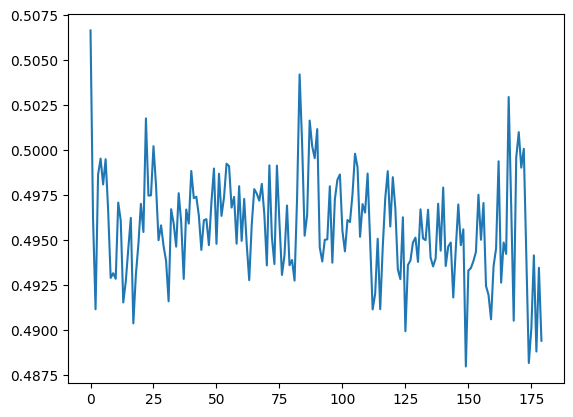

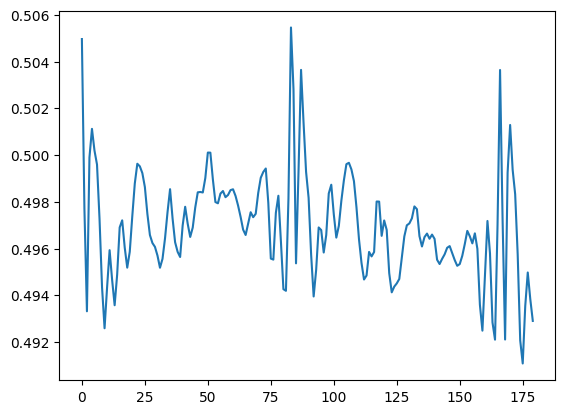

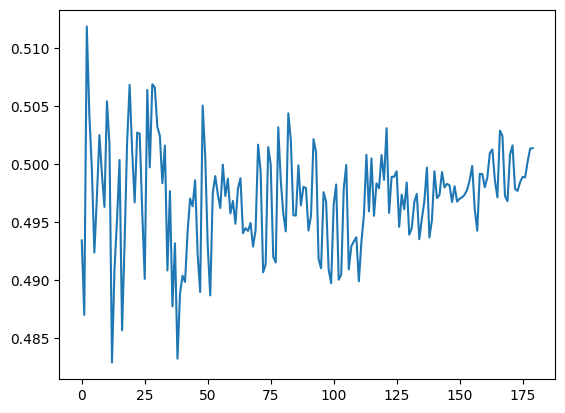

In [173]:
with torch.no_grad():

    #denoised = denoise_wavelet(data.noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    
    noise = dataset[2][0].view(1, segment_size_samples).to(device)
    clean = dataset[2][1].view(1, segment_size_samples).to(device)

    predicted = model(noise).to('cpu').view(segment_size_samples).numpy()
    clean = clean.to('cpu').view(segment_size_samples).numpy()
    noise = noise.to('cpu').view(segment_size_samples).numpy()

    print(signaltonoise_dB(clean, noise))
    print(signaltonoise_dB(clean, predicted))

    time = 180
    plt.plot(range(time), noise[:time])
    plt.show()
    plt.plot(range(time), clean[:time])
    plt.show()
    plt.plot(range(time), predicted[:time])
    plt.show()